In [ ]:
!pip install ftfy

In [ ]:
!pip install torch==1.13.1

In [ ]:
# Install PyTorch
# !conda install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.3 -c pytorch
# Install mim
!pip install -U openmim
# Install mmengine
!mim install mmengine
# Install MMCV
# !pip wheel mmcv-full==1.4.0
!mim install mmcv

In [ ]:
!rm -rf mmsegmentation
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

In [ ]:
import mmcv
import mmengine
import matplotlib.pyplot as plt
import os.path as osp
import os
from glob import glob
import numpy as np
from PIL import Image
from tqdm import tqdm

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset
print(mmseg.__version__)

In [ ]:
# define dataset root and directory for images and annotations
data_root = '/kaggle/input/leaders-of-digital-segmentation'
img_dir = 'images'
ann_dir = 'masks'
# define class and palette for better visualization
classes = ('buildings', 'background')

In [ ]:
# Download config and checkpoint files
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

In [ ]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# cfg.model.optimizer = dict(lr=0.005, momentum=0.9, type='SGD', weight_decay=0.0005)

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='RandomResize', scale=(2048, 2048), ratio_range=(0.5, 2.0), keep_ratio=True),
    # dict(type='RandomCrop', crop_size=cfg.crop_size),
    # dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    # dict(type='Resize', scale=(2048, 2048), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = "/kaggle/input/leaders-of-digital-segmentation/patches_train"
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
# cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = "/kaggle/input/leaders-of-digital-segmentation/patches_val"
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
# cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

train_cfg = dict(type='EpochBasedTrainLoop')

cfg.train_cfg.max_iters = 10000
cfg.train_cfg.val_interval = 1000
cfg.default_hooks.logger.interval = 100
cfg.default_hooks.checkpoint.interval = 1000


# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

In [ ]:
# start training
runner.train()

In [ ]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = '/kaggle/working/mmsegmentation/work_dirs/tutorial/iter_9000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('/kaggle/input/leaders-of-digital-segmentation/patches_val/images/val_111.png')
result = inference_model(model, img)
result

In [142]:
def mmseg_pred(model, img, get_buildings=True):
    result = torch.softmax(inference_model(model, img).seg_logits.data, dim=0)
    if get_buildings:
        result = result[1]#.unsqueeze(-1)
    return result.detach().cpu()

In [144]:
import numpy as np
import cv2
from tqdm import tqdm

PATCH_SIZE = 256

predict = lambda model: np.zeros_like((PATCH_SIZE, PATCH_SIZE))

def predict_full(model, path):
    img = cv2.imread(path)
    print(img.shape)
    mask = np.zeros((img.shape[0], img.shape[1]))
    for i in tqdm(range(0 * 128, img.shape[0] // PATCH_SIZE * 256, 128)):
        for j in range(0, img.shape[1] // PATCH_SIZE * 256, 128):
            patch_img = img[i:i + PATCH_SIZE, j:j + PATCH_SIZE]
            predicted = mmseg_pred(model, patch_img)
            mask[i:i + PATCH_SIZE, j:j + PATCH_SIZE] = predicted    
    return mask


for fn in sorted(glob('/kaggle/input/leaders-of-digital-segmentation-test/images/*')):
    mask = predict_full(model, fn)
    cv2.imwrite(fn.split('/')[-1].replace('image', 'mask'), mask)

In [208]:
for fn in sorted(glob('/kaggle/input/leaders-of-digital-segmentation-test/images/*')):
    mask = predict_full(model, fn)
    cv2.imwrite(fn.split('/')[-1].replace('image', 'mask'), mask)

(3763, 4838, 3)


100%|██████████| 28/28 [00:21<00:00,  1.33it/s]


(4643, 4279, 3)


100%|██████████| 36/36 [00:25<00:00,  1.42it/s]


(4868, 5784, 3)


100%|██████████| 38/38 [00:36<00:00,  1.05it/s]


(5885, 6584, 3)


100%|██████████| 44/44 [00:45<00:00,  1.04s/it]


(4966, 7851, 3)


100%|██████████| 38/38 [00:47<00:00,  1.25s/it]


(2554, 3784, 3)


100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


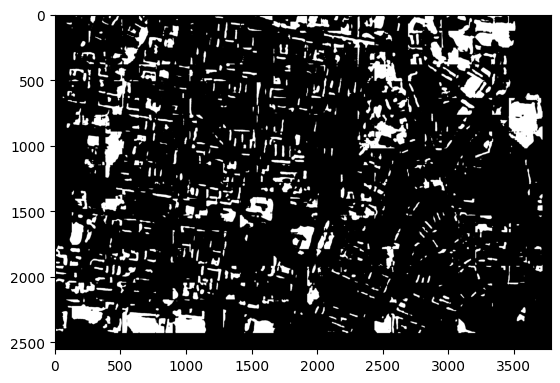

In [215]:
from PIL import Image

mask_abob = Image.open('test_mask_007.png')
plt.imshow(np.array(mask_abob), cmap='gray')

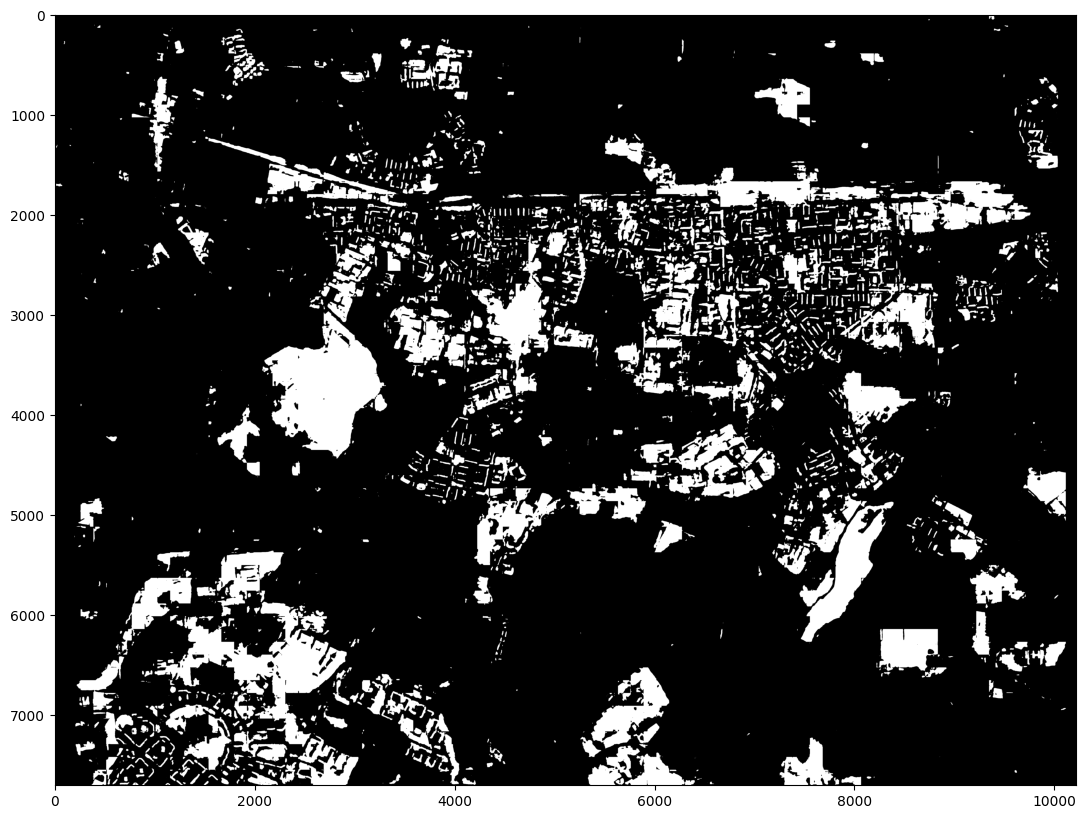

In [149]:
plt.figure(figsize=(15, 10))
plt.imshow(mask1 > 0.5, cmap='gray')

In [191]:
from glob import glob
from sklearn.metrics import f1_score


def get_model_metrics(model, img, true_mask, thresh=0.4):
    pred_mask = mmseg_pred(model, img) > thresh
#     return {'f1': f1_score(true_mask[:, :, 0].flatten(), pred_mask.flatten())}
    return f1_score(true_mask[:, :, 0].flatten(), pred_mask.flatten())

f1_scores = []
for img_path in tqdm(sorted(glob('/kaggle/input/leaders-of-digital-segmentation/patches_val/images/*'))):
    mask_path = img_path.replace('images', 'masks')
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    if mask.any():
        patch_f1 = get_model_metrics(model, img, mask)
        f1_scores.append(patch_f1)

100%|██████████| 7678/7678 [04:22<00:00, 29.29it/s]


In [192]:
np.mean(f1_scores)

0.6904855245426574

In [189]:
f1_scores

[0.3955056179775281,
 0.5266089108910891,
 0.8688742823862219,
 0.49253365973072216,
 0.6620625073159312,
 0.7780628608082105,
 0.8163026976526917,
 0.7282908022764825,
 0.8650156450869576,
 0.7411459299091415,
 0.6544105245403947,
 0.7498405125787035,
 0.8469349997944332,
 0.7267413541159279,
 0.3528774542992552,
 0.8460063897763579,
 0.4330139519246932,
 0.8139207936550042,
 0.8962592962592963,
 0.7648331935968179,
 0.8731484833128212,
 0.7537336652146857,
 0.7150829081632654,
 0.6345198867591776,
 0.9171659741963699,
 0.7037948452273022,
 0.6294339622641509,
 0.5804749340369393,
 0.9009597308795885,
 0.7002162518784592,
 0.7317117117117118,
 0.7722730471498945,
 0.8176885512750949,
 0.5628415300546448,
 0.2949018011600692,
 0.5977933801404213,
 0.8109923443593816,
 0.9118821394256433,
 0.8496967513360957,
 0.7216777321108652,
 0.7566727131381187,
 0.7039957939011567,
 0.7965321375186846,
 0.7167294413057125,
 0.6412174691476437,
 0.6851445412930331,
 0.5939619630269983,
 0.736468200